In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, brightness_range=[0.2,0.7], rescale=1./255, zoom_range = [0.5,1.0])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 5075 images belonging to 47 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Valid/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 282 images belonging to 47 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
conv_base = ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
for layer in conv_base.layers[:165]:
  layer.trainable = False
for layer in conv_base.layers[165:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn True
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn True
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn True
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn True
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn True
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn True
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn True
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn True
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn True
37 conv2_block3_add False
38 conv2_block3_out Fals

In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,1))

In [ ]:
x = Conv2D(3,(3,3), padding='same')(input_tensor)

In [ ]:
x = conv_base(x)

In [ ]:
x = Flatten()(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
out = Dense(47, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = out)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              205522944 
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 47)               

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/DTD dataset/dtd/Resnet50_DTD_SGDGreyscale.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=634,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=35,epochs=75,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
634/634 [==============================] - ETA: 0s - loss: 7.5240 - accuracy: 0.2303
Epoch 00001: val_loss improved from inf to 14.14573, saving model to /content/drive/My Drive/DTD dataset/dtd/Resnet50_DTD_SGDGreyscale.h5
634/634 [==============================] - 1733s 3s/step - loss: 7.5240 - accuracy: 0.2303 - val_loss: 14.1457 - val_accuracy: 0.0464
Epoch 2/75
634/634 [==============================] - ETA: 0s - loss: 6.4764 - accuracy: 0.3558
Epoch 00002: val_loss improved from 14.14573 to 6.17725, saving model to /content/drive/My Drive/DTD dataset/dtd/Resnet50_DTD_SGDGreyscale.h5
634/634 [==============================] - 69s 109ms/step - loss: 6.4764 - accuracy: 0.3558 - val_loss: 6.1773 - val_accuracy: 0.4429
Epoch 3/75
634/634 [==============================] - ETA: 0s - loss: 6.2146 - accuracy: 0.4073
Epoch 00003: val_loss did not improve from 6.17725
634/634 [============================

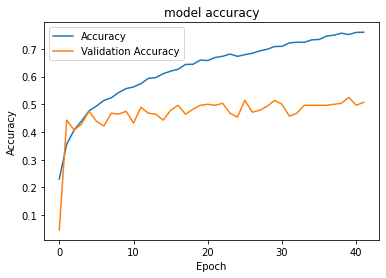

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

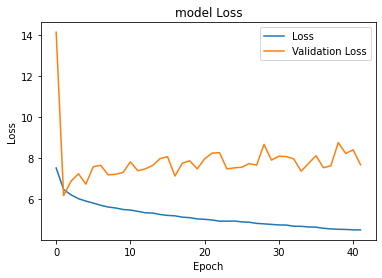

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 283 images belonging to 47 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 0, 17,  0,  0, 15,  0,  8,  9, 28, 15, 28,  1, 11,  2, 29,  2, 11,
        4,  8,  8,  8,  3, 13, 36, 27, 43, 36, 16, 27,  3, 27, 16,  5,  5,
       16, 16,  6,  6,  6,  8,  6,  6,  7,  7,  7,  7,  1, 25, 19, 16, 15,
        8, 41,  8,  9,  9,  9,  9,  9, 36, 27, 30, 10, 27, 30,  3, 36, 11,
       11, 37, 11, 11,  8, 32, 12,  8, 27, 12, 13, 27, 36, 32, 13, 13, 24,
       14, 25, 41, 21, 14, 15, 15, 17, 15, 34, 15, 16, 16, 16, 16, 16, 16,
        8,  8, 15, 35, 17, 17, 18, 18, 25, 25, 18,  6, 35, 19, 19, 19, 19,
       41, 31, 27, 27, 20, 20, 44, 11, 21,  8, 21, 21, 21,  8,  8, 15, 22,
       22, 17, 21, 28, 17, 28, 42,  9, 32, 28,  8, 28, 24, 24, 16, 25, 16,
       27, 25, 16, 26, 26, 26, 11, 26, 26, 27, 27, 27, 27, 16, 27,  4, 12,
        1,  8, 44, 12, 29, 22, 17, 29, 29, 15, 27, 27, 27, 30, 27, 10, 27,
        8,  8, 13, 36, 28, 32, 32, 32, 34, 32, 23, 33, 20,  8, 27, 44, 25,
        9,  8, 45,  6, 34, 32, 35,  8,  2, 41, 35, 35, 28, 27, 16, 36,  3,
       36, 15, 27, 34, 37

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.43109540636042404


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.5360685634844491


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.43109540636042404


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.43701107514727877


In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Train/', target_size=(224,224), batch_size=8)

Found 5075 images belonging to 47 classes.


In [ ]:
Colour_ValidData =  TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Valid/', target_size=(224,224), batch_size=8)

Found 282 images belonging to 47 classes.


In [ ]:
conv_base_colour = ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
for layer in conv_base.layers[:165]:
  layer.trainable = False
for layer in conv_base.layers[165:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,3))

In [ ]:
x = conv_base_colour(input_tensor)

In [ ]:
x = Flatten()(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
out = Dense(47, activation='softmax')(x)

In [ ]:
model_colour = Model(inputs = input_tensor, outputs = out)

In [ ]:
model_colour.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/DTD dataset/dtd/ResNet50_DTD_SGDColour.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model_colour.fit_generator(steps_per_epoch=634,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=35,epochs=75,callbacks=callBacks)

Epoch 1/75
634/634 [==============================] - ETA: 0s - loss: 7.5055 - accuracy: 0.2287
Epoch 00001: val_loss improved from inf to 8.24403, saving model to /content/drive/My Drive/DTD dataset/dtd/ResNet50_DTD_SGDColour.h5
634/634 [==============================] - 109s 172ms/step - loss: 7.5055 - accuracy: 0.2287 - val_loss: 8.2440 - val_accuracy: 0.1536
Epoch 2/75
634/634 [==============================] - ETA: 0s - loss: 6.3346 - accuracy: 0.3848
Epoch 00002: val_loss improved from 8.24403 to 6.62042, saving model to /content/drive/My Drive/DTD dataset/dtd/ResNet50_DTD_SGDColour.h5
634/634 [==============================] - 110s 173ms/step - loss: 6.3346 - accuracy: 0.3848 - val_loss: 6.6204 - val_accuracy: 0.4000
Epoch 3/75
634/634 [==============================] - ETA: 0s - loss: 6.0115 - accuracy: 0.4494
Epoch 00003: val_loss did not improve from 6.62042
634/634 [==============================] - 105s 165ms/step - loss: 6.0115 - accuracy: 0.4494 - val_loss: 8.5254 - val_a

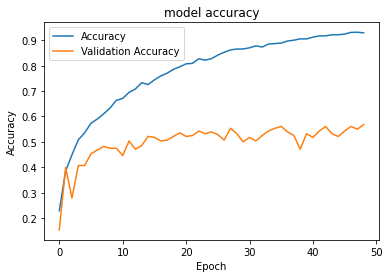

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

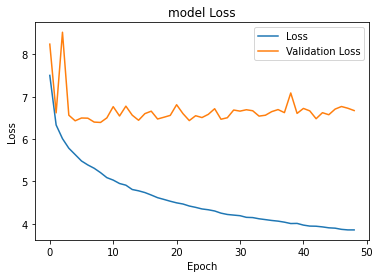

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 283 images belonging to 47 classes.


In [ ]:
Colour_predict = model_colour.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 0, 17,  0,  0,  5,  0, 24,  1, 25, 34, 28, 36,  2,  2, 42, 44, 11,
       36,  3,  3, 30,  3, 36,  3, 25, 43, 36, 27,  4, 36,  3, 10,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  8,  7,  7, 28,  7,  8, 25,  8,
       27,  8,  8, 34,  9,  9, 34,  8, 36, 10, 30, 10, 27, 10, 10, 25, 11,
       11, 24, 11,  6,  8,  8, 12, 27, 27, 12, 13, 13, 13,  3, 13, 13, 45,
       14, 14, 41, 36, 14,  8, 15, 17,  3, 20,  8,  5, 27, 30, 25, 21, 16,
       17, 17, 22, 35, 41, 16, 18, 18, 18, 16, 18,  6, 19, 19, 19, 19, 19,
       21, 12,  8, 27, 20, 20, 45, 41, 21, 41, 21, 21, 27,  3,  3, 22,  3,
       29,  0, 26, 28,  1, 36, 23, 15, 28, 28, 25,  8,  8, 24, 16, 16, 16,
       25, 16, 16,  8, 41, 41, 46, 41, 41, 27, 27, 27, 27, 16, 27,  4, 12,
       36, 27, 33,  8, 29, 22, 17, 29, 22, 29, 27, 10, 27, 30, 30, 10, 27,
       27, 28, 31,  8, 31,  8, 32, 32, 32, 32, 32, 33, 25,  8, 36, 18, 33,
       36, 36, 34, 24, 34, 36, 35,  3, 38, 35,  6, 35, 36, 36,  3, 36, 36,
       36,  3, 15, 41,  8

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.46996466431095407


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.5608783442705704


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.46996466431095407


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.4733044733044733


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_Predict_classes

array([ 0, 17,  0,  0,  5,  0, 24,  9, 25, 34, 28, 36,  2,  2, 42, 44, 11,
       36,  3,  3, 30,  3, 36, 36, 25, 43, 36, 27, 27,  3,  3, 16,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  8,  7,  7, 28,  7, 19, 16,  8,
       27,  8,  8, 34,  9,  9,  9,  8, 36, 10, 30, 10, 27, 10, 10, 25, 11,
       11, 24, 11,  6,  8,  8, 12, 27, 27, 12, 13, 13, 36,  3, 13, 13, 45,
       14, 14, 41, 21, 14, 15, 15, 17,  3, 20,  8, 16, 16, 16, 25, 16, 16,
       17, 17, 22, 35, 17, 16, 18, 18, 18, 16, 18,  6, 35, 19, 19, 19, 19,
       41, 12,  8, 27, 20, 20, 45, 41, 21, 41, 21, 21, 27,  8,  8, 15,  3,
       22,  0, 26, 28,  1, 36, 23, 15, 36, 28,  8,  8,  8, 24, 16, 25, 16,
       25, 16, 16,  8, 41, 26, 46, 41, 26, 27, 27, 27, 27, 16, 27,  4, 12,
       36, 27, 33,  8, 29, 22, 17, 29, 29, 29, 27, 10, 27, 30, 30, 10, 27,
       27, 28, 13, 13, 31,  8, 32, 32, 32, 32, 32, 33, 25,  8, 27, 18, 33,
        9, 36, 34, 24, 34, 36, 35,  8, 38, 41,  6, 35, 36, 36,  8, 36, 36,
       36,  3, 15, 41,  8

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.4840989399293286


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.5699404664465189


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.4840989399293286


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.48284395870402835


In [ ]:
Second_Final = 0.5* Colour_predict + 0.5 * Grey_predict

In [ ]:
Second_predict_classes = np.argmax(Second_Final, axis=1)

In [ ]:
Second_predict_classes

array([ 0, 17,  0,  0,  5,  0, 24,  9, 25, 34, 28, 36,  2,  2, 42, 44, 11,
       36,  3,  3, 30,  3, 36, 36, 25, 43, 36, 27, 27,  3,  3, 16,  5,  5,
        5, 16,  6,  6,  6,  6,  6,  6,  7,  8,  7,  7, 28,  7, 19, 16,  8,
       27,  8,  8, 34,  9,  9,  9,  9, 36, 10, 30, 10, 27, 10, 10, 25, 11,
       11, 24, 11,  6,  8,  8, 12, 27, 27, 12, 13, 13, 36,  3, 13, 13, 45,
       14, 14, 41, 21, 14, 15, 15, 17,  3, 20, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 22, 35, 17, 16, 18, 18, 18, 16, 18,  6, 35, 19, 19, 19, 19,
       41, 12,  8, 27, 20, 20, 45, 41, 21, 41, 21, 21, 27,  8,  8, 15, 22,
       22,  0, 21, 28,  1, 36, 23, 15, 36, 28,  8,  8,  8, 24, 16, 25, 16,
       27, 16, 16,  8, 41, 26, 46, 41, 26, 27, 27, 27, 27, 16, 27,  4, 12,
       36, 27, 33,  8, 29, 22, 17, 29, 29, 29, 27, 10, 27, 30, 30, 10, 27,
       27, 28, 13, 13, 31,  8, 32, 32, 32, 32, 32, 33, 20,  8, 27, 18, 25,
        9, 36, 34, 24, 34, 36, 35,  8, 38, 41,  6, 35, 36, 36,  8, 36,  3,
       36, 15, 15, 41, 37

In [ ]:
Second_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_predict_classes)
Second_Final_accuracy

0.4911660777385159